In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from nltk.tokenize import wordpunct_tokenize
from sklearn.linear_model import LogisticRegression
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem import WordNetLemmatizer
import re
import string

### Inserting fake and real dataset

In [2]:
df = pd.read_csv("train.csv") 
df.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


label
0    10387
1    10413
Name: label, dtype: int64


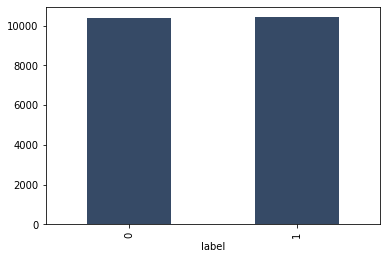

In [3]:
print(df.groupby(['label'])['label'].count())
df.groupby(['label'])['label'].count().plot(kind="bar", color="#364a66")
plt.show()

## Preprocessed Text

In [4]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords') 
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/emabaranauskaite/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
# text word count
df['word_count'] = df['text'].apply(lambda x: len(str(x).split()))
print(df[df['label']==1]['word_count'].mean()) # fake articles
print(df[df['label']==0]['word_count'].mean()) # reliable articles

639.0722174205321
878.9965341292


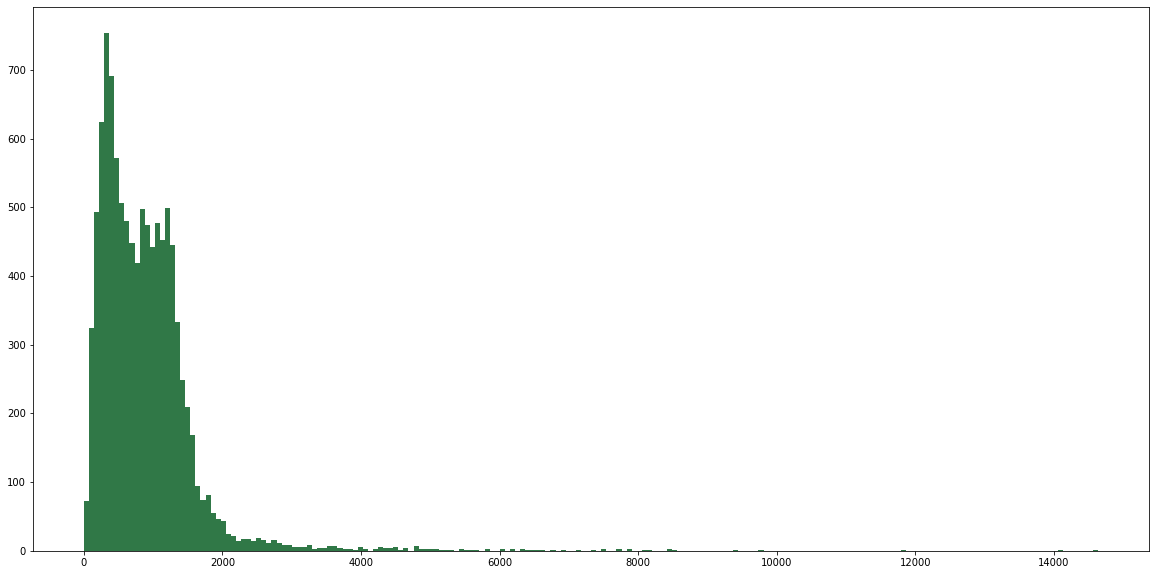

Number of real articles with zero words:  0


In [6]:
x = df[df['label']==0]['word_count']
plt.figure(figsize=(20,10)) 
plt.hist(x, bins = 200, color="#307847")
plt.show() 
print("Number of real articles with zero words: ", len(df[(df['label']==0) & (df['word_count']==0)])) 

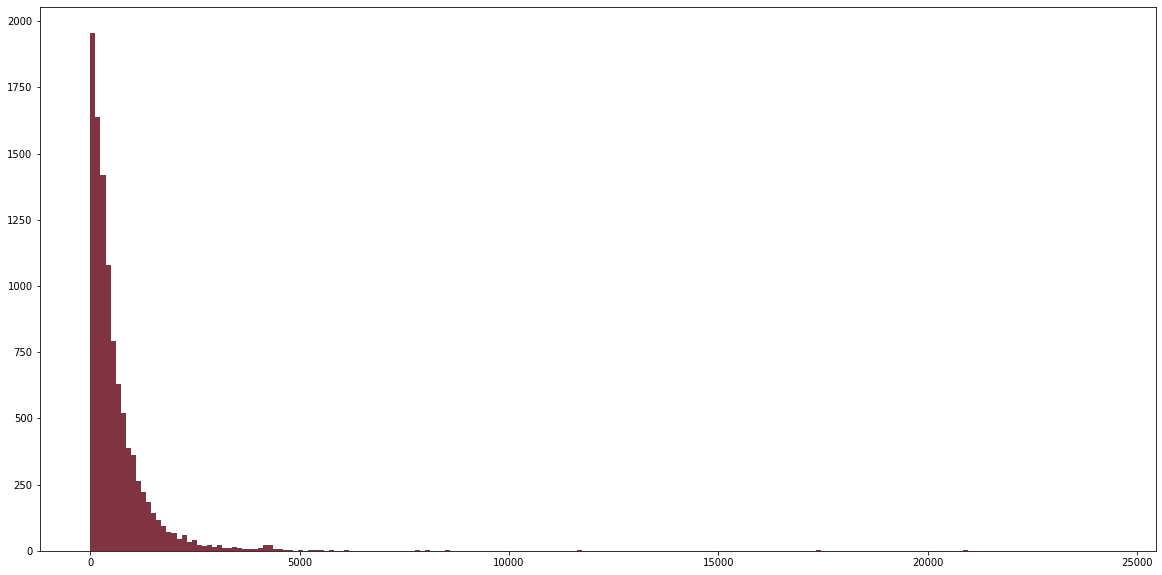

Number of fake articles with zero words:  77


In [7]:
x = df[df['label']==1]['word_count']
plt.figure(figsize=(20,10)) 
plt.hist(x, bins = 200, color="#803441")
plt.show()
print("Number of fake articles with zero words: ", len(df[(df['label']==1) & (df['word_count']==0)])) 

In [8]:
lemmatizer = WordNetLemmatizer()
ps = PorterStemmer()

def preprocess(text):
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub("\\W"," ",text) 
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)   
    return lemmatizer.lemmatize(text)

In [9]:
df = df.fillna('')
df["article"] = df["title"] + " " + df["author"] + " " + df["text"]
df["article"] = df["article"].apply(preprocess)

In [10]:
# Most frequent words in real articles
real = df[df['label'] == 0]['article'].str.cat(sep = ' ')
list_of_words = [i.lower() for i in wordpunct_tokenize(real) if i.lower() not in stop_words and i.isalpha()]
wordfreqreal = nltk.FreqDist(list_of_words)
mostcommonreal = wordfreqreal.most_common(30)
print(mostcommonreal)

[('said', 67487), ('mr', 64512), ('trump', 37489), ('new', 25599), ('would', 22461), ('one', 22318), ('people', 19634), ('president', 16583), ('like', 15880), ('also', 15228), ('ms', 12397), ('york', 12380), ('times', 11894), ('could', 11858), ('time', 11784), ('state', 11420), ('years', 11343), ('two', 11301), ('many', 11137), ('first', 10969), ('states', 10872), ('last', 10763), ('year', 10137), ('united', 10069), ('even', 9969), ('news', 9446), ('american', 9069), ('government', 8511), ('house', 8393), ('clinton', 8349)]


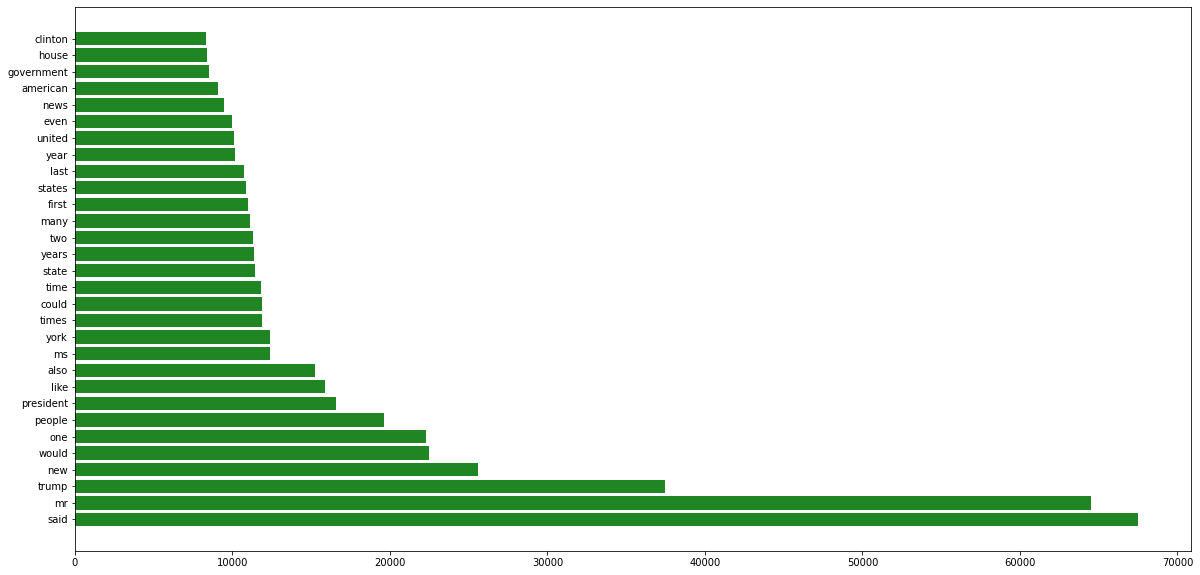

In [11]:
plt.figure(figsize=(20,10)) 
plt.barh(range(len(mostcommonreal)),[val[1] for val in mostcommonreal], align='center', color="#208523")
plt.yticks(range(len(mostcommonreal)), [val[0] for val in mostcommonreal])
plt.show()

In [12]:
# Most frequent words in fake articles
fake = df[df['label'] == 1]['text'].str.cat(sep = ' ')
list_of_words = [i.lower() for i in wordpunct_tokenize(fake) if i.lower() not in stop_words and i.isalpha()]
wordfreqfake = nltk.FreqDist(list_of_words)
mostcommonfake = wordfreqfake.most_common(30)
print(mostcommonfake)

[('trump', 20147), ('clinton', 19254), ('people', 16598), ('one', 16126), ('us', 14921), ('would', 14555), ('hillary', 12762), ('said', 11875), ('new', 10395), ('like', 10319), ('also', 9921), ('time', 9235), ('world', 9180), ('state', 8906), ('even', 8856), ('president', 8508), ('election', 8263), ('government', 8145), ('many', 7967), ('war', 7625), ('obama', 7547), ('could', 7448), ('american', 6976), ('u', 6936), ('russia', 6742), ('states', 6567), ('media', 6544), ('de', 6525), ('years', 6472), ('first', 6327)]


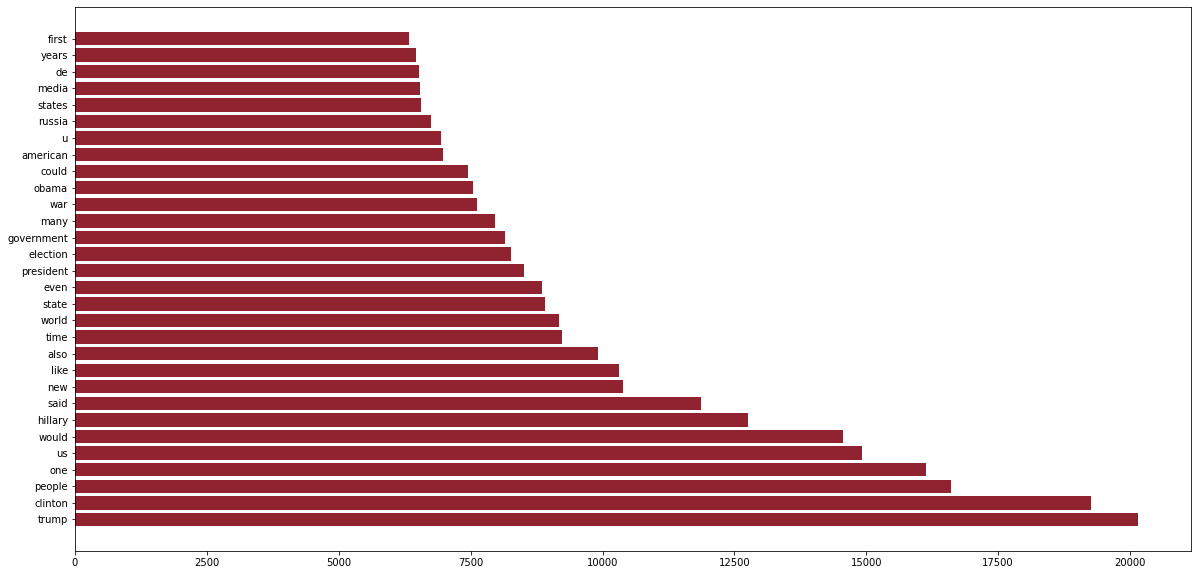

In [13]:
plt.figure(figsize=(20,10)) 
plt.barh(range(len(mostcommonfake)),[val[1] for val in mostcommonfake], align='center', color="#912330")
plt.yticks(range(len(mostcommonfake)), [val[0] for val in mostcommonfake])
plt.show()

## Training

In [14]:
article = df['article'].values
labels = df['label'].values
print(df['article'])

0        house dem aide  we didn t even see comey s let...
1        flynn  hillary clinton  big woman on campus   ...
2        why the truth might get you fired consortiumne...
3         civilians killed in single us airstrike have ...
4        iranian woman jailed for fictional unpublished...
                               ...                        
20795    rapper t i   trump a  poster child for white s...
20796    n f l  playoffs  schedule  matchups and odds  ...
20797    macy s is said to receive takeover approach by...
20798    nato  russia to hold parallel exercises in bal...
20799    what keeps the f  alive david swanson   david ...
Name: article, Length: 20800, dtype: object


#### Splitting the dataset into training set and testing set. 

In [15]:
train_data, test_data, train_labels, test_labels = train_test_split(article, labels, test_size=0.25)

#### From text to numeric. Getting tfidf values

In [16]:
vectorization = TfidfVectorizer()
train_data = vectorization.fit_transform(train_data)
test_data = vectorization.transform(test_data)

In [17]:
models = {}

### 1. Logistic Regression

In [18]:
LR = LogisticRegression()
LR.fit(train_data, train_labels)

LogisticRegression()

In [19]:
predictionLr = LR.predict(test_data)

In [20]:
LR.score(test_data, test_labels)

0.9534615384615385

In [21]:
models[LR] = LR.score(test_data, test_labels)

In [22]:
print(classification_report(test_labels, predictionLr))

              precision    recall  f1-score   support

           0       0.95      0.95      0.95      2609
           1       0.95      0.95      0.95      2591

    accuracy                           0.95      5200
   macro avg       0.95      0.95      0.95      5200
weighted avg       0.95      0.95      0.95      5200



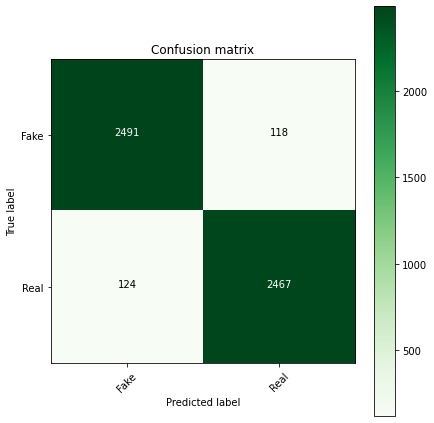

In [23]:
from sklearn import metrics
import itertools

cm = metrics.confusion_matrix(test_labels, predictionLr)

plt.figure(figsize=(6, 6)) 

plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Greens)
plt.title('Confusion matrix')
plt.colorbar()

plt.xticks(np.arange(len(['Fake', 'Real'])), ['Fake', 'Real'], rotation=45)
plt.yticks(np.arange(len(['Fake', 'Real'])), ['Fake', 'Real'])
 
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j],
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

### 2. Decision Tree Classification

In [24]:
from sklearn.tree import DecisionTreeClassifier

In [25]:
DT = DecisionTreeClassifier()
DT.fit(train_data, train_labels)

DecisionTreeClassifier()

In [26]:
predictionDT = DT.predict(test_data)

In [27]:
DT.score(test_data, test_labels)

0.9609615384615384

In [28]:
models[DT] = DT.score(test_data, test_labels)

In [29]:
print(classification_report(test_labels, predictionDT))

              precision    recall  f1-score   support

           0       0.96      0.96      0.96      2609
           1       0.96      0.96      0.96      2591

    accuracy                           0.96      5200
   macro avg       0.96      0.96      0.96      5200
weighted avg       0.96      0.96      0.96      5200



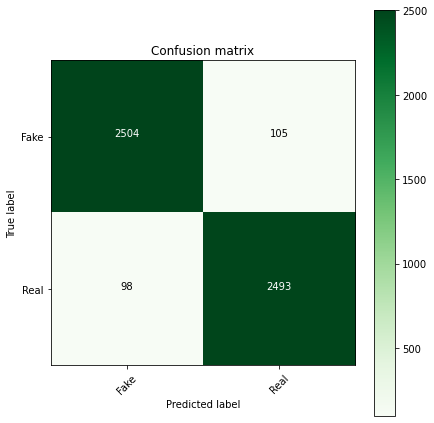

In [30]:
from sklearn import metrics
import itertools

cm = metrics.confusion_matrix(test_labels, predictionDT)

plt.figure(figsize=(6, 6)) 

plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Greens)
plt.title('Confusion matrix')
plt.colorbar()

plt.xticks(np.arange(len(['Fake', 'Real'])), ['Fake', 'Real'], rotation=45)
plt.yticks(np.arange(len(['Fake', 'Real'])), ['Fake', 'Real'])
 
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j],
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

### 3. K-Nearest Neighbors Boosting Classifier

In [31]:
from sklearn.neighbors import KNeighborsClassifier

KN = KNeighborsClassifier(n_neighbors=2)
KN.fit(train_data, train_labels)

KNeighborsClassifier(n_neighbors=2)

In [32]:
predictionKN = KN.predict(test_data)

In [33]:
KN.score(test_data, test_labels)

0.8075

In [34]:
models[KN] = KN.score(test_data, test_labels)

In [35]:
print(classification_report(test_labels, predictionKN))

              precision    recall  f1-score   support

           0       0.77      0.89      0.82      2609
           1       0.86      0.73      0.79      2591

    accuracy                           0.81      5200
   macro avg       0.82      0.81      0.81      5200
weighted avg       0.81      0.81      0.81      5200



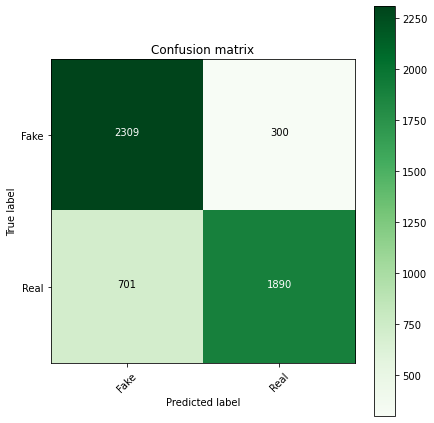

In [36]:
from sklearn import metrics
import itertools

cm = metrics.confusion_matrix(test_labels, predictionKN)

plt.figure(figsize=(6, 6)) 

plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Greens)
plt.title('Confusion matrix')
plt.colorbar()

plt.xticks(np.arange(len(['Fake', 'Real'])), ['Fake', 'Real'], rotation=45)
plt.yticks(np.arange(len(['Fake', 'Real'])), ['Fake', 'Real'])
 
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j],
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

### 4. Gradient Boosting Classifier

In [37]:
from sklearn.ensemble import GradientBoostingClassifier

In [38]:
GBC = GradientBoostingClassifier(random_state=0)
GBC.fit(train_data, train_labels)

GradientBoostingClassifier(random_state=0)

In [39]:
predictionGBC = GBC.predict(test_data)

In [40]:
GBC.score(test_data, test_labels)

0.9659615384615384

In [41]:
models[GBC] = GBC.score(test_data, test_labels)

In [42]:
print(classification_report(test_labels, predictionGBC))

              precision    recall  f1-score   support

           0       0.97      0.96      0.97      2609
           1       0.96      0.97      0.97      2591

    accuracy                           0.97      5200
   macro avg       0.97      0.97      0.97      5200
weighted avg       0.97      0.97      0.97      5200



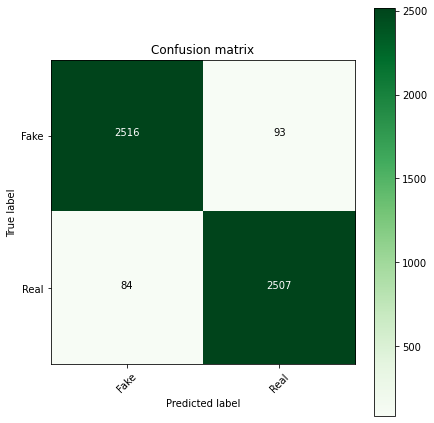

In [43]:
from sklearn import metrics
import itertools

cm = metrics.confusion_matrix(test_labels, predictionGBC)

plt.figure(figsize=(6, 6)) 

plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Greens)
plt.title('Confusion matrix')
plt.colorbar()

plt.xticks(np.arange(len(['Fake', 'Real'])), ['Fake', 'Real'], rotation=45)
plt.yticks(np.arange(len(['Fake', 'Real'])), ['Fake', 'Real'])
 
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j],
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

### 5. SVM (Support Vector Machine)

In [44]:
from sklearn import svm

In [45]:
SVM = svm.SVC()
SVM.fit(train_data, train_labels)

SVC()

In [46]:
predictionSVM = SVM.predict(test_data)

In [47]:
SVM.score(test_data, test_labels)

0.9734615384615385

In [48]:
models[SVM] = SVM.score(test_data, test_labels)

In [49]:
print(classification_report(test_labels, predictionSVM))

              precision    recall  f1-score   support

           0       0.97      0.97      0.97      2609
           1       0.97      0.97      0.97      2591

    accuracy                           0.97      5200
   macro avg       0.97      0.97      0.97      5200
weighted avg       0.97      0.97      0.97      5200



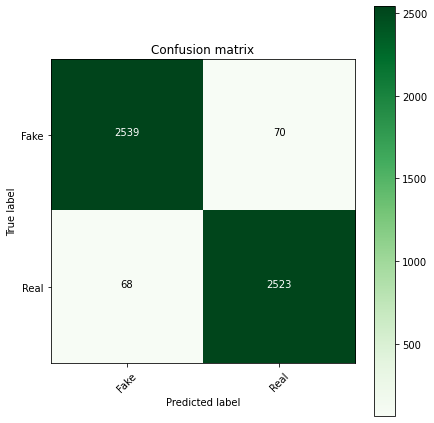

In [50]:
from sklearn import metrics
import itertools

cm = metrics.confusion_matrix(test_labels, predictionSVM)

plt.figure(figsize=(6, 6)) 

plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Greens)
plt.title('Confusion matrix')
plt.colorbar()

plt.xticks(np.arange(len(['Fake', 'Real'])), ['Fake', 'Real'], rotation=45)
plt.yticks(np.arange(len(['Fake', 'Real'])), ['Fake', 'Real'])
 
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j],
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

### Neural Network

In [51]:
from sklearn.neural_network import MLPClassifier

In [52]:
MLPC = MLPClassifier()
MLPC.fit(train_data, train_labels)

MLPClassifier()

In [53]:
predictionMLPC = MLPC.predict(test_data)

In [54]:
MLPC.score(test_data, test_labels)

0.9728846153846153

In [55]:
models[MLPC] = MLPC.score(test_data, test_labels)

In [56]:
print(classification_report(test_labels, predictionMLPC))

              precision    recall  f1-score   support

           0       0.97      0.97      0.97      2609
           1       0.97      0.97      0.97      2591

    accuracy                           0.97      5200
   macro avg       0.97      0.97      0.97      5200
weighted avg       0.97      0.97      0.97      5200



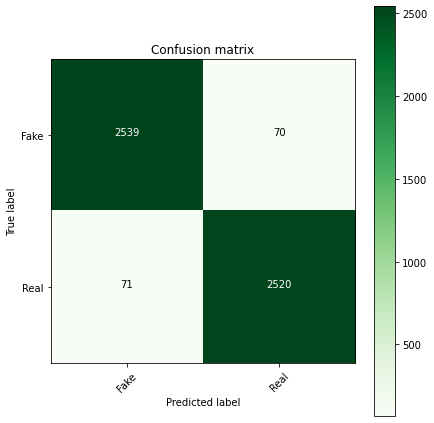

In [57]:
from sklearn import metrics
import itertools

cm = metrics.confusion_matrix(test_labels, predictionMLPC)

plt.figure(figsize=(6, 6)) 

plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Greens)
plt.title('Confusion matrix')
plt.colorbar()

plt.xticks(np.arange(len(['Fake', 'Real'])), ['Fake', 'Real'], rotation=45)
plt.yticks(np.arange(len(['Fake', 'Real'])), ['Fake', 'Real'])
 
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j],
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

## Choosing Best Model

In [58]:
best_model = max(models, key=models.get)

testdata = pd.read_csv('test.csv')
 
testdata = testdata.fillna('') 

testdata["article"] = testdata["title"] + " " + testdata["author"] + " " + testdata["text"]

testdata['article'] = testdata['article'].apply(preprocess) 
testdatavalues = testdata['article'].values 
  
newcontent = vectorization.transform(testdatavalues) 
testdata['label'] = best_model.predict(newcontent)

newdf = pd.DataFrame()
newdf["id"] = testdata["id"]
newdf["label"] = testdata["label"]  
display(newdf)

newdf.to_csv('submit.csv', index=False)

,id,label
0,20800,0
1,20801,1
2,20802,1
3,20803,0
4,20804,1
...,...,...
5195,25995,0
5196,25996,0
5197,25997,0
5198,25998,1
